In [ ]:
params = {
    'epochs': [50, 30],
    'model': 'ResNet18',
    'train_batch_size': 64,
    'val_batch_size': 64,
    'optimizer': 'Adam',
    'learning_rate': [0.001, 0.00001]
}

# TODOs 
# Clean up code
# validation set - DONE
# Augmentation - DONE
# 2 phase transfer learning - DONE
# hyperparameter tuning - sortof done
# automating runs (only change 1 cell)
# find workaround for Drive login?

In [ ]:
!pip install torchmetrics
!pip install neptune-client
import neptune.new as neptune
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import time
import torchmetrics
import random
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from zipfile import ZipFile
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DataPath = '/content/drive/MyDrive/WEDS/fire_dataset.zip'

with ZipFile(DataPath, 'r') as z:
  # z.printdir()
  print('extracting...')
  z.extractall(path='/content')
  print('done!')

extracting...
done!


In [ ]:
fire_ims = glob('/content/fire_dataset/fire_images/*')
non_fire_ims = glob('/content/fire_dataset/non_fire_images/*')

random.seed(42)
random.shuffle(fire_ims)
random.shuffle(non_fire_ims)


print(len(fire_ims))
print(len(non_fire_ims))
print(non_fire_ims[0])

# 755
# 805

799
797
/content/fire_dataset/non_fire_images/non_fire.115.png


In [ ]:
TrainPaths = []
ValPaths = []

for i, path in enumerate(fire_ims):
  if i<100:
    ValPaths.append((path, 1))
  else:
    TrainPaths.append((path, 1))


for i, path in enumerate(non_fire_ims):
  if i<100:
    ValPaths.append((path, 0))
  else:
    TrainPaths.append((path, 0))

print(len(TrainPaths))
print(len(ValPaths))
print(ValPaths[95:105])

1396
200
[('/content/fire_dataset/fire_images/fire.231.png', 1), ('/content/fire_dataset/fire_images/fire.566.png', 1), ('/content/fire_dataset/fire_images/fire.186.png', 1), ('/content/fire_dataset/fire_images/fire.596.png', 1), ('/content/fire_dataset/fire_images/fire.461.png', 1), ('/content/fire_dataset/non_fire_images/non_fire.115.png', 0), ('/content/fire_dataset/non_fire_images/sunset175.jpg', 0), ('/content/fire_dataset/non_fire_images/clouds402.jpg', 0), ('/content/fire_dataset/non_fire_images/sunset348.jpg', 0), ('/content/fire_dataset/non_fire_images/sunset988.jpg', 0)]


In [ ]:
class FireDataset(torch.utils.data.Dataset): #TODO preprocess transforms AND runtime transforms?

  def __init__(self, paths, transforms = None, augumentations = None):
    self.data = paths
    self.num_ims = len(self.data)
    self.augumentations = augumentations

    self.x, self.y = list(zip((*self.data)))
    self.images = []
    for path in self.x:
      image = Image.open(path)
      if image.mode != 'RGB':
        print('Converting to RGB: ', path)
        image = image.convert('RGB')
      if transforms != None:
        image = transforms(image)
      self.images.append(image)
      if image.shape != (3, 224, 224):
        print('Image still has wrong shape: ', path, ' ', image.shape)
    print(f'Found {self.num_ims} images.')
  
  def __getitem__(self, idx):

    image = self.images[idx]
    label = self.y[idx]

    if self.augumentations:
      image = self.augumentations(image)

    return image, label

  def __len__(self):
    return self.num_ims

Converting to RGB:  /content/fire_dataset/fire_images/fire.548.png
Converting to RGB:  /content/fire_dataset/fire_images/fire.309.png
Converting to RGB:  /content/fire_dataset/fire_images/fire.354.png
Converting to RGB:  /content/fire_dataset/non_fire_images/non_fire.116.png
Converting to RGB:  /content/fire_dataset/non_fire_images/non_fire.189.png
Converting to RGB:  /content/fire_dataset/non_fire_images/non_fire.151.png
Converting to RGB:  /content/fire_dataset/non_fire_images/non_fire.128.png
Converting to RGB:  /content/fire_dataset/non_fire_images/non_fire.160.png
Found 1396 images.
Converting to RGB:  /content/fire_dataset/fire_images/fire.367.png
Found 200 images.



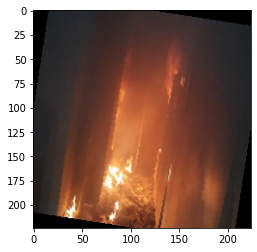

In [ ]:
trs = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
augs = transforms.Compose([
                           transforms.RandomRotation(degrees=(0, 30)),
                           transforms.RandomHorizontalFlip(p=0.5),
                           ])
train_dataset = FireDataset(TrainPaths, trs, augumentations=augs)
val_dataset = FireDataset(ValPaths, trs)
print()
# print(len(train_dataset))
plt.imshow(train_dataset[0][0].permute(1, 2, 0))

P



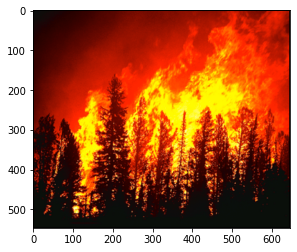

In [ ]:
wierd_image = Image.open('/content/fire_dataset/fire_images/fire.548.png')
print(wierd_image.mode)
wierd_image.convert('RGB')
print()
plt.imshow(wierd_image)

In [ ]:
#transformed_image = trs(wierd_image)
#print(transforms.ToTensor()(wierd_image).shape)
#print(transformed_image.shape)
##plt.imshow(transformed_image.permute(1, 2, 0))

In [ ]:
#normal_image = Image.open('/content/fire_dataset/fire_images/fire.1.png')
#print(normal_image.mode)
#plt.imshow(normal_image)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=params['train_batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=params['val_batch_size'], shuffle=True, num_workers=2)

In [ ]:
# This is legacy...

# RootPath = '/content/fire_dataset'

#trs = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

#FireDataset = torchvision.datasets.ImageFolder(root=RootPath, transform=trs)

In [ ]:
#print(FireDataset)
#print()
#print(type(FireDataset))
#print()
#print(len(FireDataset))
#print()
#print(FireDataset[0])
#print()
#print(FireDataset.class_to_idx)
#print()
#print(FireDataset[0][0].shape)

In [ ]:
#train_loader = DataLoader(FireDataset, batch_size=params['batch_size'], shuffle=True, num_workers=2)

In [ ]:
model = models.resnet18(pretrained=True, progress=True)
# model = models.vgg16(pretrained=True, progress=True)
# model = models.resnet50(pretrained=True, progress=True)

In [ ]:
# print(model)

In [ ]:
model.fc=nn.Linear(in_features=512, out_features=1)
#model.classifier=nn.Linear(in_features=25088, out_features=1)
#model.fc=nn.Linear(in_features=2048, out_features=1)

In [ ]:
# print(model)

In [ ]:
for param in model.parameters():
  param.requires_grad = False

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [ ]:
opt = optim.Adam(model.parameters(), lr = params['learning_rate'][0])
criterion = nn.BCEWithLogitsLoss()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [ ]:
with open("/content/drive/MyDrive/APITOKEN.txt", "r") as f:
  NEPTUNE_API_TOKEN = f.read()
run = neptune.init(project="kgele/Fire-detection", api_token=NEPTUNE_API_TOKEN)
run["parameters"] = params

https://app.neptune.ai/kgele/Fire-detection/e/FIR-16
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
train_acc_metric = torchmetrics.Accuracy().to(device)
val_acc_metric = torchmetrics.Accuracy().to(device)
num_epochs = params['epochs'][0]

for epoch in range(num_epochs):
  #epoch_start = time.time()
  for i, data in enumerate(train_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    model.train()
    opt.zero_grad()

    outputs = model(inputs)
    labels = labels
    outputs = outputs.squeeze()
    loss = criterion(outputs, labels.float())
    loss.backward()
    opt.step()

    batch_accuracy = train_acc_metric(outputs, labels)
    #print('outputs ', outputs.shape)
    #print('labels' , labels)
    #print('accuracy ', accuracy)
    #writer.add_scalar('Loss/Batch', loss, i)
    #writer.add_scalar('Accuracy/Batch', batch_accuracy, i)
    run['batch/train/loss'].log(loss)
    run['batch/train/accuracy'].log(batch_accuracy)
  #break
  epoch_accuracy = train_acc_metric.compute()
  #writer.add_scalar('Accuracy/Epoch', epoch_accuracy, epoch)
  run['epoch/train/accuracy'].log(epoch_accuracy)
  print(f'Finished epoch {epoch} of {num_epochs}')
  print(f'Epoch accuracy: {epoch_accuracy}')

  for i, data in enumerate(val_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    model.eval()
    outputs = model(inputs)
    outputs = outputs.squeeze()
    loss = criterion(outputs, labels.float())
    batch_accuracy = val_acc_metric(outputs, labels)

  epoch_val_accuracy = val_acc_metric.compute()
  #writer.add_scalar('Val_Accuracy/Epoch', epoch_val_accuracy, epoch)
  run['epoch/val/accuracy'].log(epoch_val_accuracy)
  print(f'Epoch val accuracy: {epoch_val_accuracy}')
  print()

# run.stop()

Finished epoch 0 of 50
Epoch accuracy: 0.6303724646568298
Epoch val accuracy: 0.8500000238418579

Finished epoch 1 of 50
Epoch accuracy: 0.7159742116928101
Epoch val accuracy: 0.862500011920929

Finished epoch 2 of 50
Epoch accuracy: 0.7683858871459961
Epoch val accuracy: 0.8733333349227905

Finished epoch 3 of 50
Epoch accuracy: 0.7985315322875977
Epoch val accuracy: 0.8862500190734863

Finished epoch 4 of 50
Epoch accuracy: 0.8216332197189331
Epoch val accuracy: 0.8999999761581421

Finished epoch 5 of 50
Epoch accuracy: 0.8345271944999695
Epoch val accuracy: 0.9075000286102295

Finished epoch 6 of 50
Epoch accuracy: 0.8459885120391846
Epoch val accuracy: 0.9142857193946838

Finished epoch 7 of 50
Epoch accuracy: 0.8568230867385864
Epoch val accuracy: 0.9162499904632568

Finished epoch 8 of 50
Epoch accuracy: 0.8650907278060913
Epoch val accuracy: 0.9211111068725586

Finished epoch 9 of 50
Epoch accuracy: 0.8721346855163574
Epoch val accuracy: 0.921999990940094

Finished epoch 10 of 5

In [ ]:
for param in model.parameters():
  param.requires_grad = True
opt = optim.Adam(model.parameters(), lr = params['learning_rate'][1])

train_acc_metric = torchmetrics.Accuracy().to(device)
val_acc_metric = torchmetrics.Accuracy().to(device)
num_epochs = params['epochs'][1]

for epoch in range(num_epochs):
  for i, data in enumerate(train_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    model.train()
    opt.zero_grad()

    outputs = model(inputs)
    labels = labels
    outputs = outputs.squeeze()
    loss = criterion(outputs, labels.float())
    loss.backward()
    opt.step()

    batch_accuracy = train_acc_metric(outputs, labels)
    run['batch/train/loss'].log(loss)
    run['batch/train/accuracy'].log(batch_accuracy)

  epoch_accuracy = train_acc_metric.compute()
  run['epoch/train/accuracy'].log(epoch_accuracy)
  print(f'Finished epoch {epoch} of {num_epochs}')
  print(f'Epoch accuracy: {epoch_accuracy}')

  for i, data in enumerate(val_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    model.eval()
    outputs = model(inputs)
    outputs = outputs.squeeze()
    loss = criterion(outputs, labels.float())
    batch_accuracy = val_acc_metric(outputs, labels)

  epoch_val_accuracy = val_acc_metric.compute()
  run['epoch/val/accuracy'].log(epoch_val_accuracy)
  print(f'Epoch val accuracy: {epoch_val_accuracy}')
  print()

# run.stop()

Finished epoch 0 of 30
Epoch accuracy: 0.9477077126502991
Epoch val accuracy: 0.949999988079071

Finished epoch 1 of 30
Epoch accuracy: 0.9573782086372375
Epoch val accuracy: 0.949999988079071

Finished epoch 2 of 30
Epoch accuracy: 0.9651384949684143
Epoch val accuracy: 0.95333331823349

Finished epoch 3 of 30
Epoch accuracy: 0.9709885120391846
Epoch val accuracy: 0.956250011920929

Finished epoch 4 of 30
Epoch accuracy: 0.9746418595314026
Epoch val accuracy: 0.9589999914169312

Finished epoch 5 of 30
Epoch accuracy: 0.9771967530250549
Epoch val accuracy: 0.9616666436195374

Finished epoch 6 of 30
Epoch accuracy: 0.9796357154846191
Epoch val accuracy: 0.9621428847312927

Finished epoch 7 of 30
Epoch accuracy: 0.9819126129150391
Epoch val accuracy: 0.9637500047683716

Finished epoch 8 of 30
Epoch accuracy: 0.9833651781082153
Epoch val accuracy: 0.9644444584846497

Finished epoch 9 of 30
Epoch accuracy: 0.9845272302627563
Epoch val accuracy: 0.9660000205039978

Finished epoch 10 of 30
E

In [ ]:
torch.save(model, '/content/ResNet18')
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


In [ ]:
model2 = torch.load('/content/ResNet18')
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  